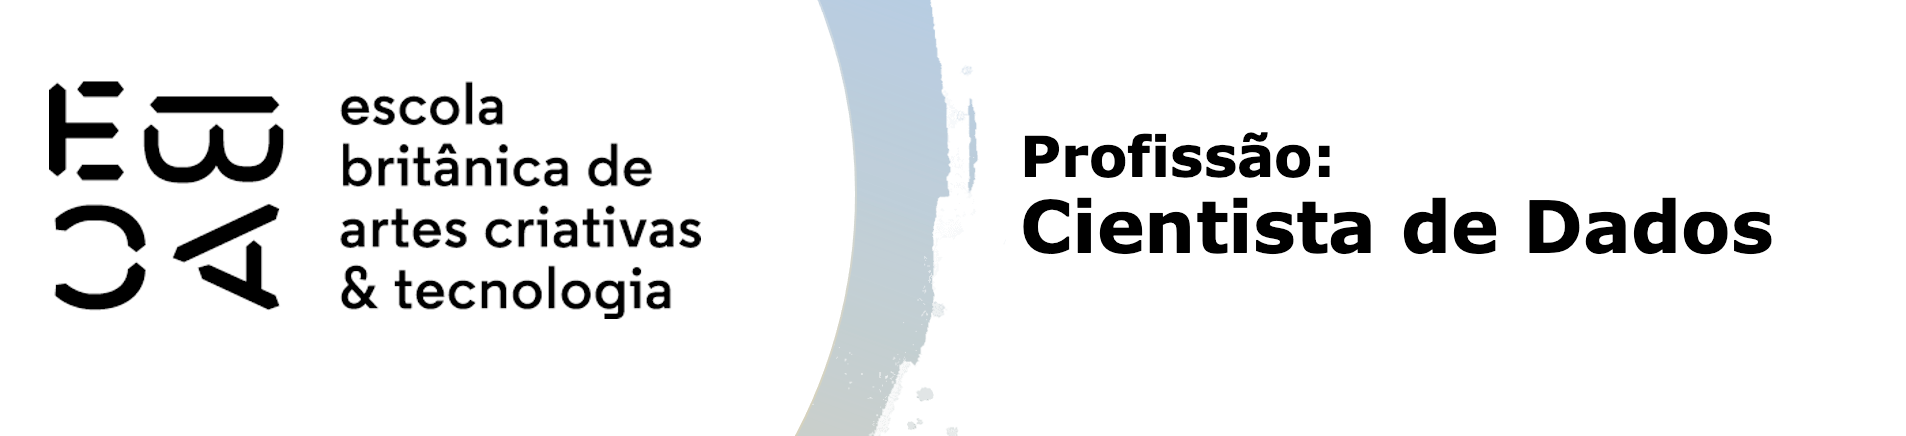

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_pickle('base_nfp.pkl')
df.rename(columns={'Data Emissão':'Data_Emissão'}, inplace=True)
df.set_index('Data_Emissão', inplace=True)
df_apartir2020 = df['2020-01-01':]
df_apartir2020.dropna(inplace=True)
df_apartir2020.reset_index(inplace=True)
df_apartir2020.head(2)

,Data_Emissão,CNPJ emit.,Emitente,No.,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,2020-01-01,05.234.750/0001-41,TX BURGER LTDA,77882,78.80,2020-08-01,0.0,A Calcular,2019,2,0.0,0,não definido
1,2020-01-01,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,22.71,2020-01-01,0.0,A Calcular,2019,2,0.0,0,Mercado


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [4]:
# Supondo que o DataFrame 'df_cut' já tenha sido carregado e a coluna 'Data_Emissão' esteja no tipo datetime
df_apartir2020['Dia_Semana'] = df_apartir2020['Data_Emissão'].dt.day_name()
df_apartir2020['Fim_de_semana'] = ((df_apartir2020['Data_Emissão'].dt.dayofweek) // 5 == 1).astype(float) # 1 = fim de semana, 0 = dia útil
df_apartir2020['Dia_do_Mes'] = df_apartir2020['Data_Emissão'].dt.day  # Dia do mês
df_apartir2020['Mes'] = df_apartir2020['Data_Emissão'].dt.month # Mes
df_apartir2020['Trimestre'] = df_apartir2020['Data_Emissão'].dt.quarter  # Trimestre do ano
df_apartir2020['Ano'] = df_apartir2020['Data_Emissão'].dt.year # Ano

# Exibir as primeiras linhas para verificar os novos atributos
df_apartir2020.head(2)


,Data_Emissão,CNPJ emit.,Emitente,No.,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria,Dia_Semana,Fim_de_semana,Dia_do_Mes,Mes,Trimestre
0,2020-01-01,05.234.750/0001-41,TX BURGER LTDA,77882,78.80,2020-08-01,0.0,A Calcular,2020,2,0.0,0,não definido,Wednesday,0.0,1,1,1
1,2020-01-01,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,22.71,2020-01-01,0.0,A Calcular,2020,2,0.0,0,Mercado,Wednesday,0.0,1,1,1


In [6]:
# Criando categorizações da variável 'Valor NF' usando quantis em diferentes categorias

# 5 quantis
df_apartir2020['Valor_NF_Q5'] = pd.qcut(df_apartir2020['Valor NF'], 5, labels=False, duplicates='drop')

# 10 quantis
df_apartir2020['Valor_NF_Q10'] = pd.qcut(df_apartir2020['Valor NF'], 10, labels=False, duplicates='drop')

# 20 quantis
df_apartir2020['Valor_NF_Q20'] = pd.qcut(df_apartir2020['Valor NF'], 20, labels=False, duplicates='drop')

# 50 quantis
df_apartir2020['Valor_NF_Q50'] = pd.qcut(df_apartir2020['Valor NF'], 50, labels=False, duplicates='drop')

# Exibindo as primeiras linhas do DataFrame com as novas colunas de quantis

df_apartir2020.head(3)

,Data_Emissão,CNPJ emit.,Emitente,No.,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,...,categoria,Dia_Semana,Fim_de_semana,Dia_do_Mes,Mes,Trimestre,Valor_NF_Q5,Valor_NF_Q10,Valor_NF_Q20,Valor_NF_Q50
0,2020-01-01,05.234.750/0001-41,TX BURGER LTDA,77882,78.80,2020-08-01,0.0,A Calcular,2020,2,...,não definido,Wednesday,0.0,1,1,1,2,5,10,27
1,2020-01-01,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,22.71,2020-01-01,0.0,A Calcular,2020,2,...,Mercado,Wednesday,0.0,1,1,1,0,1,3,8
2,2020-01-01,09.060.964/0108-39,PIMENTA VERDE ALIMENTOS LTDA,82366,35.90,2020-08-01,0.0,A Calcular,2020,2,...,Alimentos,Wednesday,0.0,1,1,1,1,2,5,14


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [7]:
df_apartir2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86000 entries, 0 to 85999
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Data_Emissão         86000 non-null  datetime64[ns]
 1   CNPJ emit.           86000 non-null  object        
 2   Emitente             86000 non-null  object        
 3   No.                  86000 non-null  int64         
 4   Valor NF             86000 non-null  float64       
 5   Data Registro        86000 non-null  datetime64[ns]
 6   Créditos             86000 non-null  float64       
 7   Situação do Crédito  86000 non-null  category      
 8   Ano                  86000 non-null  int32         
 9   Semestre             86000 non-null  int64         
 10  Retorno              86000 non-null  float64       
 11  flag_credito         86000 non-null  int64         
 12  categoria            86000 non-null  object        
 13  Dia_Semana           86000 non-

In [8]:
df_apartir2020.columns

Index(['Data_Emissão', 'CNPJ emit.', 'Emitente', 'No.', 'Valor NF',
       'Data Registro', 'Créditos', 'Situação do Crédito', 'Ano', 'Semestre',
       'Retorno', 'flag_credito', 'categoria', 'Dia_Semana', 'Fim_de_semana',
       'Dia_do_Mes', 'Mes', 'Trimestre', 'Valor_NF_Q5', 'Valor_NF_Q10',
       'Valor_NF_Q20', 'Valor_NF_Q50'],
      dtype='object')

In [9]:
#Criando os metadados
df_short = df_apartir2020.drop(columns=['Data_Emissão', 'CNPJ emit.', 'Emitente', 'No.', 'Valor NF', 'Data Registro', 'Créditos', 
                     'Situação do Crédito', 'Retorno'])

metadados = pd.DataFrame({'dtype':df_short.dtypes})
metadados

,dtype
Ano,int32
Semestre,int64
flag_credito,int64
categoria,object
Dia_Semana,object
Fim_de_semana,float64
Dia_do_Mes,int32
Mes,int32
Trimestre,int32
Valor_NF_Q5,int64


In [11]:
# Atribuindo papéis

metadados['papel'] = 'covariavel'
metadados.loc['flag_credito','papel'] = 'resposta'
metadados['nunique'] = df_apartir2020.nunique()
metadados

,dtype,papel,nunique
Ano,int32,covariavel,2
Semestre,int64,covariavel,2
flag_credito,int64,resposta,2
categoria,object,covariavel,9
Dia_Semana,object,covariavel,7
Fim_de_semana,float64,covariavel,2
Dia_do_Mes,int32,covariavel,31
Mes,int32,covariavel,12
Trimestre,int32,covariavel,4
Valor_NF_Q5,int64,covariavel,5


In [15]:
# Definindo a função

def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [16]:
# Populando a metadados

for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'nunique']>50):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_short[var],5,duplicates='drop'), df_short.flag_credito)
    else: 
        metadados.loc[var, 'IV'] = IV(df_short[var], df_short.flag_credito)
    
metadados

,dtype,papel,nunique,IV
Ano,int32,covariavel,2,0.002589
Semestre,int64,covariavel,2,0.003679
flag_credito,int64,resposta,2,NaN
categoria,object,covariavel,9,0.240964
Dia_Semana,object,covariavel,7,0.006784
Fim_de_semana,float64,covariavel,2,0.005311
Dia_do_Mes,int32,covariavel,31,0.012432
Mes,int32,covariavel,12,0.007772
Trimestre,int32,covariavel,4,0.003010
Valor_NF_Q5,int64,covariavel,5,0.044709


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

### Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?

Com base nos valores de IV apresentados, as variáveis que parecem apresentar maior poder de discriminação são:

    Categoria: IV = 0.240964 (poder preditivo razoável)
    Valor_NF_Q50: IV = 0.080574 (poder preditivo fraco, mas relevante)
    Valor_NF_Q20: IV = 0.067870 (também mostra um poder de discriminação fraco)
    Valor_NF_Q10: IV = 0.056499

Estas variáveis têm os maiores valores de IV, sugerindo que são as mais preditivas no modelo.

Portanto, a variável categoria tem um poder preditivo mais significativo, com IV = 0.240964, enquanto as outras variáveis (Valor_NF_Q50, Valor_NF_Q20, Valor_NF_Q10) têm valores de IV que indicam um poder preditivo fraco, mas ainda podem ser úteis no modelo.

### Relação entre o Número de Categorias e o IV

Quando categorizamos variáveis contínuas, parece haver uma relação direta entre o número de categorias e o valor do IV. Observando os IVs para as variáveis categorizadas com base no Valor NF:

    Valor_NF_Q5: IV = 0.044709
    Valor_NF_Q10: IV = 0.056499
    Valor_NF_Q20: IV = 0.067870
    Valor_NF_Q50: IV = 0.080574

Conforme o número de categorias aumenta (5, 10, 20, 50 quantis), o valor do IV também aumenta, sugerindo que a discriminação melhora conforme a variável contínua é dividida em mais categorias.


## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

In [18]:
df_apartir2020_2 = df_apartir2020.groupby(['Trimestre', 'flag_credito']).size().unstack(fill_value=0)
df_apartir2020_2['soma'] = df_apartir2020_2.sum(axis=1)
df_apartir2020_2

flag_credito,0,1,soma
Trimestre,,,
1,11397,9146,20543
2,11847,8231,20078
3,12377,9720,22097
4,13061,10221,23282


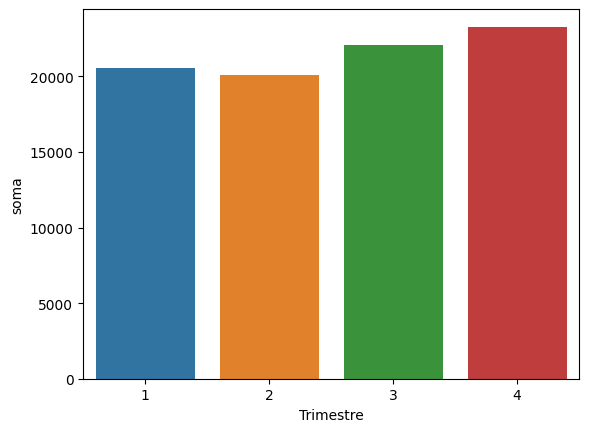

In [24]:
# Definindo uma paleta de cores personalizada
cores = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Cores diferentes para cada barra

# Criando o gráfico de barras com cores diferentes
ax = plt.subplots()

sns.barplot(data=df_apartir2020_2.reset_index(), 
            x='Trimestre', 
            y='soma', 
            errorbar=None, 
            palette=cores,
            dodge=False,
            hue = 'Trimestre',
            legend=False) 
plt.show()

In [32]:
#A quantidade de notas por categoria e por período
df_apartir2020_3 = df_apartir2020.groupby(['Trimestre', 'categoria', 'flag_credito']).size().unstack(fill_value=0)
df_apartir2020_3['soma'] = df_apartir2020_3.sum(axis=1)
df_apartir2020_3['tx_evento'] = df_apartir2020_3[1]/df_apartir2020_3['soma']

df_apartir2020_3.head(3)

flag_credito             0     1  soma  tx_evento
Trimestre categoria                              
1         Alimentos    374   908  1282   0.708268
          Auto posto   118    34   152   0.223684
          Construção  2041  1811  3852   0.470145

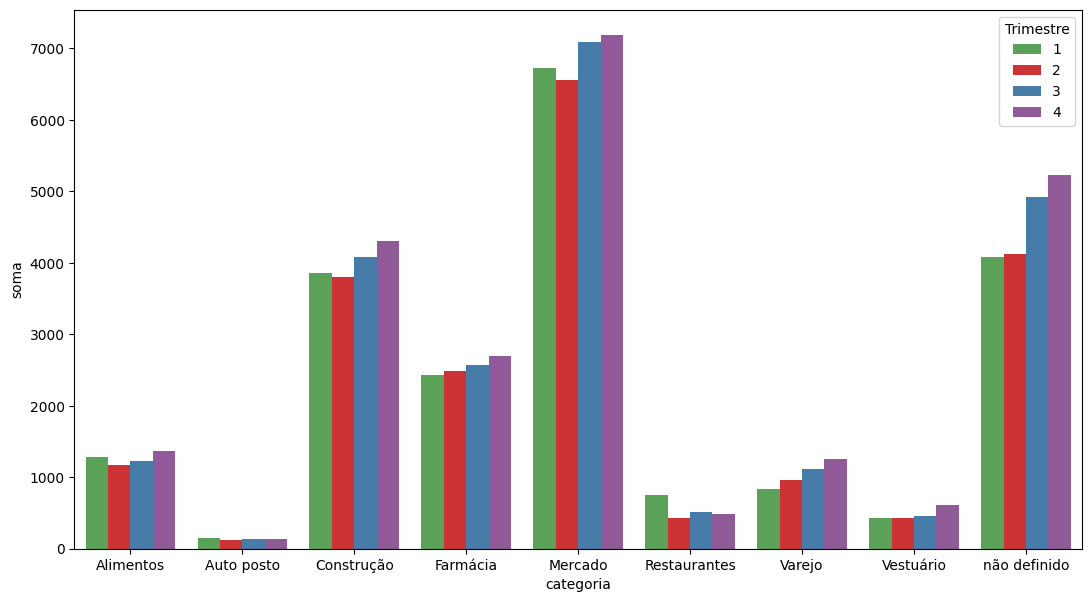

In [40]:
# Definindo as cores
cores = ['#4daf4a', '#e41a1c', '#377eb8', '#984ea3']

fig, ax = plt.subplots(figsize=(13,7))

# Criando o gráfico de barras
sns.barplot(data=df_apartir2020_3.reset_index(),
            x='categoria',
            y='soma',
            hue='Trimestre',  
            palette=cores,  
            dodge=True)     

plt.legend(title='Trimestre')
plt.show()

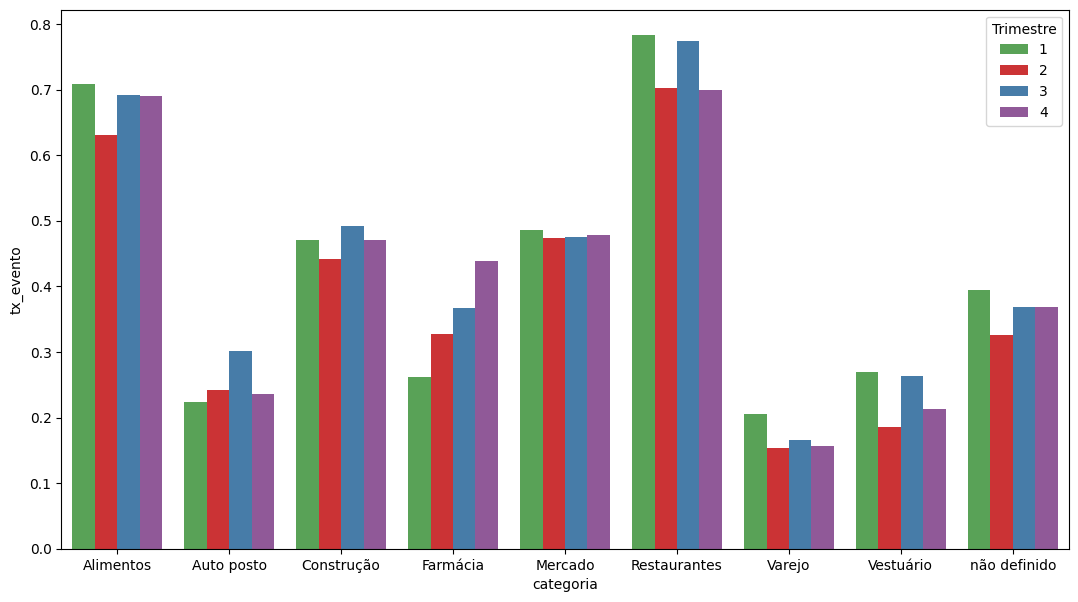

In [41]:
#- A proporção de notas com crédito por categoria por período
# Definindo as cores
cores = ['#4daf4a', '#e41a1c', '#377eb8', '#984ea3']

fig, ax = plt.subplots(figsize=(13,7))

# Criando o gráfico de barras
sns.barplot(data=df_apartir2020_3.reset_index(),
            x='categoria',
            y='tx_evento',
            hue='Trimestre',  
            palette=cores,  
            dodge=True)     

plt.legend(title='Trimestre')
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [44]:
df_apartir2020_3.head(2)

flag_credito            0    1  soma  tx_evento
Trimestre categoria                            
1         Alimentos   374  908  1282   0.708268
          Auto posto  118   34   152   0.223684

In [45]:
rotulo_ev, rotulo_nev = (1, 0)

df_apartir2020_3['pct_evento']     = df_apartir2020_3[rotulo_ev]/df_apartir2020_3[rotulo_ev].groupby(level=0).sum()
df_apartir2020_3['pct_nao_evento'] = df_apartir2020_3[rotulo_nev]/df_apartir2020_3[rotulo_nev].groupby(level=0).sum()
df_apartir2020_3['WOE'] = np.log(df_apartir2020_3.pct_evento/df_apartir2020_3.pct_nao_evento)
df_apartir2020_3.head()

flag_credito             0     1  soma  tx_evento  pct_evento  pct_nao_evento  \
Trimestre categoria                                                             
1         Alimentos    374   908  1282   0.708268    0.099278        0.032816   
          Auto posto   118    34   152   0.223684    0.003717        0.010354   
          Construção  2041  1811  3852   0.470145    0.198010        0.179082   
          Farmácia    1794   638  2432   0.262336    0.069757        0.157410   
          Mercado     3456  3271  6727   0.486249    0.357643        0.303238   

flag_credito               WOE  
Trimestre categoria             
1         Alimentos   1.107022  
          Auto posto -1.024291  
          Construção  0.100473  
          Farmácia   -0.813831  
          Mercado     0.165017

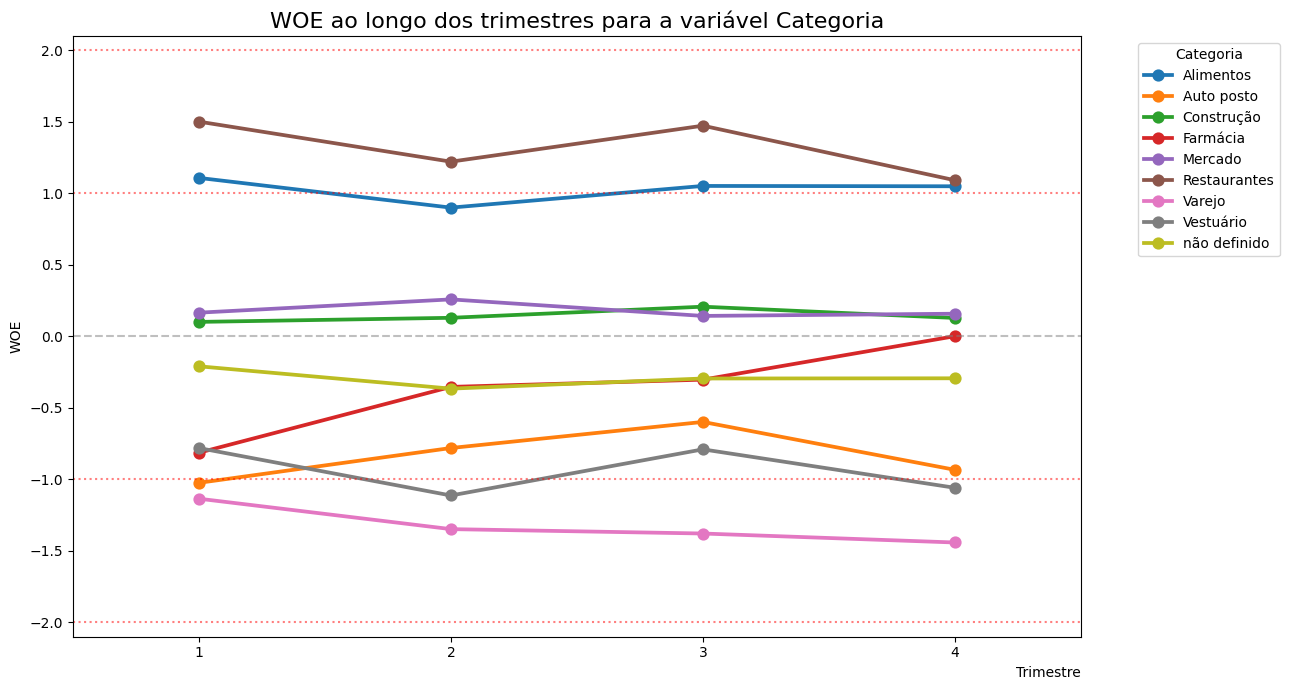

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definindo o tamanho do gráfico
fig, ax = plt.subplots(figsize=(13, 7))
variavel = 'categoria'

# Comando principal do gráfico
sns.pointplot(data=df_apartir2020_3.reset_index(), y='WOE', x='Trimestre', hue=variavel, ax=ax)

# Definindo limites do gráfico - mostrando 1 e -1 como referência
ymax = max(2.1, max(df_apartir2020_3.WOE))
ymin = min(-2.1, min(df_apartir2020_3.WOE))
ax.set_ylim([ymin, ymax])

# Linhas de referência
ax.axhline(2, linestyle=':', color='red', alpha=0.5)
ax.axhline(1, linestyle=':', color='red', alpha=0.5)
ax.axhline(0, linestyle='--', color='grey', alpha=0.5)
ax.axhline(-1, linestyle=':', color='red', alpha=0.5)
ax.axhline(-2, linestyle=':', color='red', alpha=0.5)

# Títulos
ax.set_title(f'WOE ao longo dos trimestres para a variável {variavel.capitalize()}', loc='center', fontsize=16)
ax.set_xlabel('Trimestre', loc='right')
ax.set_ylabel('WOE')

# Posicionando a legenda fora do gráfico, à direita
plt.legend(title=variavel.capitalize(), bbox_to_anchor=(1.05, 1), loc='upper left')

# Exibindo o gráfico
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()


In [54]:
def plot_iv(IV):
    fig, ax = plt.subplots()
    x = IV.index
    a = [.02]*len(IV.index)
    b = [.1]*len(IV.index)
    c = [.3]*len(IV.index)
    d = [.5]*len(IV.index)
    e = [.6]*len(IV.index)

    ax.fill_between(IV.index, a, color='grey', alpha=.2)
    ax.fill_between(IV.index, a, b, color='orange', alpha=.1)
    ax.fill_between(IV.index, b, c, color='green', alpha=.1)
    ax.fill_between(IV.index, c, d, color='blue', alpha=.1)
    ax.fill_between(IV.index, d, e, color='purple', alpha=.1)
    ax.plot(IV)

    ax.set_title("Information Value de categoria ao longo dos Trimestres")
    ax.set_ylabel("Information Value")
    ax.set_xlabel("Trimestres")

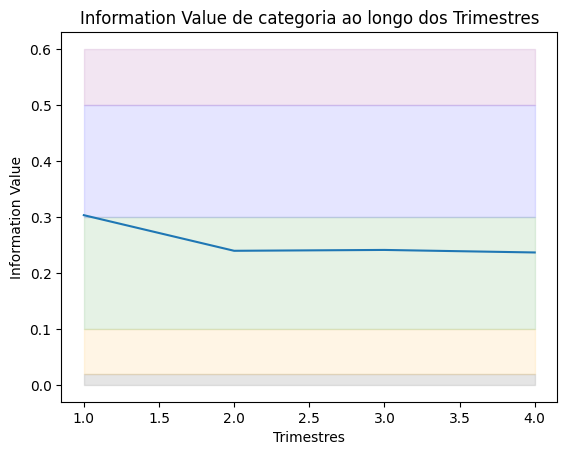

In [55]:
plot_iv(((df_apartir2020_3.pct_evento - df_apartir2020_3.pct_nao_evento)*df_apartir2020_3.WOE).groupby(level=0).sum())

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

### Conclusão

1. **Categorias com maior proporção de retornos maiores que zero**:
   - As categorias **Mercado**, **Farmácia**, e **Alimentos** apresentam a maior proporção de notas com retornos maiores que zero, conforme indicado pelo gráfico de **WOE**. Essas categorias mantêm um **Information Value (IV)** em uma faixa que indica **poder preditivo médio** (entre 0.1 e 0.3), reforçando a relevância dessas variáveis para discriminar entre as notas com e sem retorno.

2. **Estabilidade ao longo do tempo**:
   - As categorias **Mercado**, **Farmácia**, e **Alimentos** mostram estabilidade em termos de proporção de retornos ao longo dos trimestres. O **WOE** dessas categorias permanece consistente, indicando que elas continuam a ter um desempenho sólido. Além disso, o gráfico de **IV** reflete uma leve variação ao longo dos trimestres, mas sem comprometer o poder preditivo dessas variáveis.

3. **Impacto de períodos atípicos (Pandemia e Crescimento)**:
   - Mesmo com a influência da pandemia e o crescimento do público a partir de 2020, o gráfico de **IV** mantém as categorias com valores dentro de uma faixa útil de discriminação. Isso sugere que, apesar de algumas flutuações, as variáveis relacionadas a essas categorias continuam a ser relevantes para análise preditiva.

### Integração dos Gráficos

- O gráfico de **WOE** mostra o comportamento das categorias ao longo do tempo, permitindo identificar as que apresentam maior proporção de retornos > 0. 
- O gráfico de **IV** reforça que essas variáveis mantêm um bom poder preditivo, permanecendo úteis e informativas ao longo dos trimestres.
  
Com esses dois gráficos, fica claro que categorias como **Mercado**, **Farmácia**, e **Alimentos** continuam relevantes tanto em termos de proporção de retornos quanto em sua capacidade de discriminar o comportamento das notas fiscais.

### Conclusão Final

- A categoria **Mercado** se destaca como a mais relevante em termos de retornos > 0, com **WOE** consistentemente alto e **IV** estável.
- As categorias **Farmácia** e **Alimentos** também mostram relevância, com proporções de retornos maiores que a média e bom poder preditivo.
- As variações observadas ao longo do tempo não parecem impactar negativamente a discriminação das variáveis, que permanecem estáveis e informativas.